In [1]:
import nest;
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from utils.inputs import generate_piecewise_constant_signal


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jul 17 2024 10:25:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Introduction to Spiking Neural Networks


In order to start doing the standard Brunel balanced random network. This network is composed of a sparsely connected excitatory and inhibitory integrate-and-fire neurons. It can switch between asynchronous and syncrhonous states.


[1]: Brunel N (2000). Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8, 183-208.

In [2]:
#Simulation Parameters
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)
num_threads = 8

In [3]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 23 14:51:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


## 1. Stationary Spiking Neural Network - Homogenous Poisson Process

In [4]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

#### 1.2 Create Neuronal Models and Network

Leaky integrate-and-fire model where the potential jumps on each spike arrival. The threshold crossing is followed by an absolute refractory period during which the membrane potential is clamped to the resting potential. Spikes arriving while the neuron is refractory, are discarded by default.

References:

[1] Rotter S, Diesmann M (1999). Exact simulation of time-invariant linear systems with applications to neuronal modeling. Biologial Cybernetics 81:381-402. DOI: https://doi.org/10.1007/s004220050570

[2] Diesmann M, Gewaltig M-O, Rotter S, & Aertsen A (2001). State space analysis of synchronous spiking in cortical neural networks. Neurocomputing 38-40:565-571. DOI: https://doi.org/10.1016/S0925-2312(01)00409-X

In [5]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period
#Different STDP

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [6]:
#Connect Network

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

#### 1. 3 Generate Input and Connect to excitatory connection weight

In [7]:
# external input parameters (background noise)
V_th = 20.           # spike threshold (mV)
tau_m = 20.          # membrane time constant (ms)

nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 1.0 * nu_th             # set external rate above threshold
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

#### 1.4 Create and Connect external inputs

In [8]:
spikes_E_noise = nest.Create('spike_recorder')
spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
spikes_I_noise.stop = sim_time

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_i, spikes_I_noise)

#### 1.5 Simulate and Analyse

In [9]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 23 14:51:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1282 nodes for simulation.
Mean firing rate: 11.887 Hz (E: 11.678 Hz, I: 12.096 Hz)

Oct 23 14:51:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1282
    Simulation time (ms): 1000
    Number of OpenMP threads: 8
    Number of MPI processes: 1

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.1332, Real-time factor: 0.2238Model time: 427.0 ms, Real-time factor: 0.1515

Oct 23 14:51:49 SimulationManager::run [Info]: 
    Simulation finished.


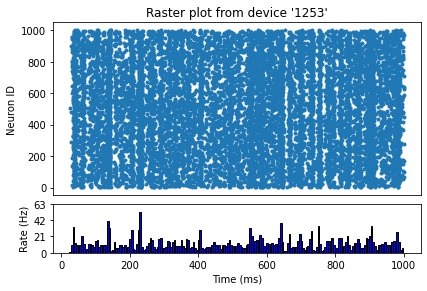

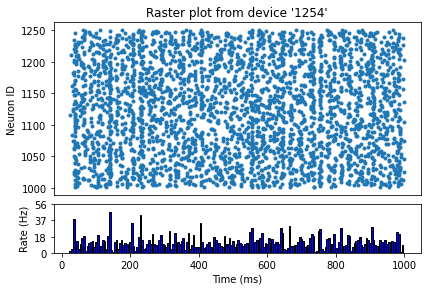

In [10]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
nest.raster_plot.from_device(spikes_I_noise, hist=True)

# 2. Stationary Spiking Neural Network - Inhomogenous Poisson Process (Stimulus)

We need to introduce a basal homogenous poisson process stimulus if not the stimulus driven input if reaches zero will imply a zero input into the netwrok, therefore, no firing and continuation

In [11]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 23 14:51:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


#### 2.1 Create Neural Models and Network

In [12]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch)
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 5.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [13]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [14]:
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
#nest.Connect(neurons_e, spikes_e)

#### 2.2 Generate Input and Connect to excitatory connection weight

In [15]:
# external input (stimulus)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)
step_duration = 20.    # [ms]
scale = p_rate/2    # scale input amplitude (max. rate)
stim_time=5000
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, 
                                                                           num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += stim_time  # stimulus starts after the noise phase

inp_amplitudes *= 2

Text(0.5, 1.0, '$u(t)$')

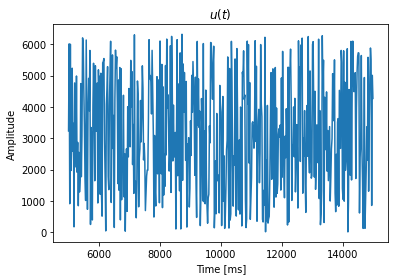

In [16]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(inp_times, inp_amplitudes)
#ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [17]:
#create poisson generator (basal noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': stim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})


# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

#### 2.3 Connect to external inputs

In [18]:
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_stim)

In [20]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 47.9725 Hz (E: 47.649 Hz, I: 48.296 Hz)


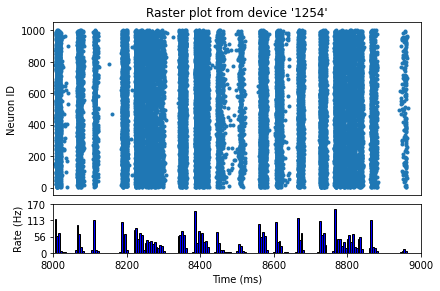

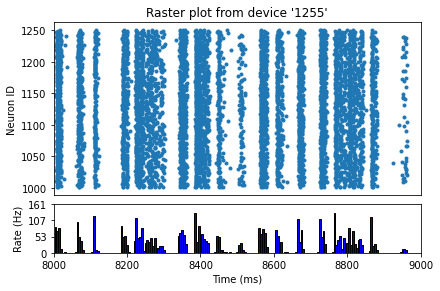

In [21]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_stim, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

# 3. Spiking Neural Network with Synapse Model - Synaptic Time Dependent Plasticity (STDP)

In [22]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 3.1 Create Neural Models And Network

In [23]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch) Put it to 10000
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [24]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [25]:
#Connect Network

# E synapses
#syn_dict = {"synapse_model": "stdp_synapse", "alpha": 0.1, "mu_plus":0.4,"mu_minus":0.4, "lambda":10, "weight":w, "tau_plus":15.0, "Wmax":90.0}
#syn_dict = {"synapse_model": "stdp_synapse", "alpha": 0.1, "mu_plus":0.4,"mu_minus":0.4, "lambda":10, "weight":w, "tau_plus":15.0, "Wmax":90.0}

#Heterogenity
#alpha_min = 0.1
#alpha = nest.random.uniform(min=alpha_min, max=alpha_max)

#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

syn_dict = {"synapse_model": "excitatory_plastic"}
            
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
nest.Connect(neurons_e, spikes_e)

#### 3.2 Generate Input and Connect to excitatory connection weight

In [26]:
# external input parameters (background noise)
V_th = 20.           # spike threshold (mV)
tau_m = 20.          # membrane time constant (ms)

nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 1. * nu_th             # set external rate above threshold (changed from 2 to 1)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

#### 3.3 Connect to external Inputs

In [27]:
spikes_E_noise = nest.Create('spike_recorder')
#spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
#spikes_I_noise.stop = sim_time

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_i, spikes_I_noise)

In [28]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 7.754149999999999 Hz (E: 6.3107 Hz, I: 9.1976 Hz)


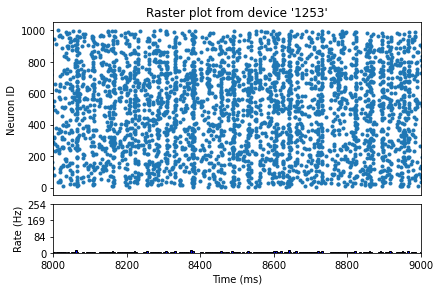

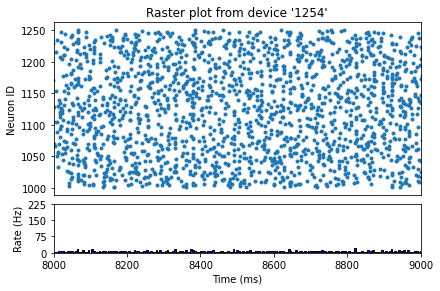

In [29]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_noise, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

**STDP tends to promote synchronization** in spiking neural networks by strengthening synapses between neurons that fire together and weakening those between asynchronously firing neurons.

[1]: Thomas Nowotny. Enhancement of Synchronization in a Hybrid Neural Circuit by Spike-Timing Dependent Plasticity. Journal of Neuroscience, 2003.

# 4. Spiking Neural Network with Synapse Model STDP - Stimulus + Noise Input

Look at the weight after 10 s, in both, and then also start driven stimulus after 5 s, before background noise

In [30]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 4.1 Create Neural Models and Network

In [31]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch)
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 5.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [32]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [33]:
#Connect Network

#Heterogenity
alpha_min = 0.1
alpha_max = 1

#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

syn_dict = {"synapse_model": "excitatory_plastic"}
            
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
nest.Connect(neurons_e, spikes_e)

#### 3.2 Stimulus Input and connection to the system

In [34]:
# external input (stimulus)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)
step_duration = 20.    # [ms]
scale = p_rate/2    # scale input amplitude (max. rate)
stim_time = 5000
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, 
                                                                           num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)

inp_times += stim_time  # stimulus starts after the noise phase

inp_amplitudes*=1.5

Text(0.5, 1.0, '$u(t)$')

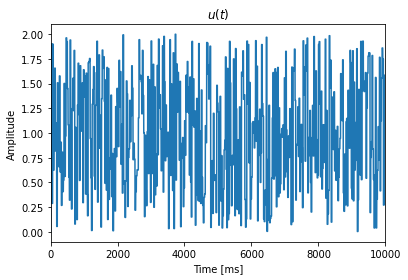

In [35]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 10000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [36]:
#create poisson generator (basal noise phase)
#noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': stim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

#### 4.3 Connect to external inputs

In [37]:
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_stim)

In [38]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 7.2044500000000005 Hz (E: 5.7057 Hz, I: 8.7032 Hz)


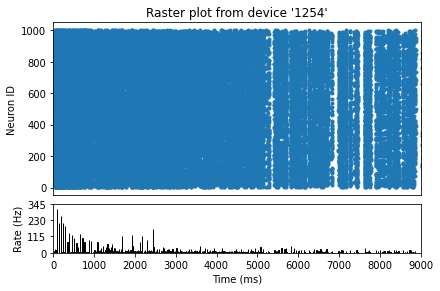

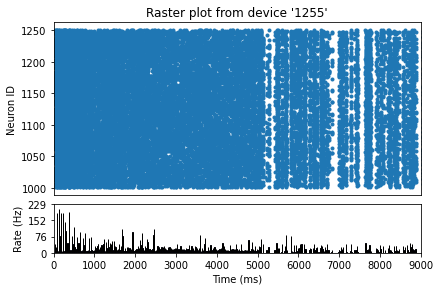

In [39]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(0, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_stim, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(0, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

# 5. Spiking Neural Network with Additive Synapse Model STDP - Noise Input

In [40]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### Create Neural Models and Network

In [41]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch) Put it to 10000
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [42]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [43]:
#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_connection_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu_plus": 0,  # weight dependence exponent for causal firing, potentiation
        "mu_plus": 0,  # weight dependence exponent for causal firing, depression
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

NESTErrors.UnknownModelName: UnknownModelName in SLI function CopyModel_l_l_D: /stdp_connection_hom is not a known model name.